<a href="https://colab.research.google.com/github/chaezz/example/blob/master/2021_05_06_PM_Neural_Network_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

미세먼지 베이스라인을 만들기 위해 Neural_Network(NN)방식을 사용하려 한다.
베이스라인은 기상 데이터(풍속, 습도, 강우량, 시간, 년중날짜)만을 이용해 미세먼지 PM2.5, PM10을 예측한다.

우선 pm2.5만 확인한다.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
# first neural network with keras make predictions
# from numpy import loadtxt

import datetime
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.4.1


### 데이터 불러오기
기상청과 에어코리아에서 2019, 2020년도의 데이터를 불러온다.
각 컬럼은 다음을 의미한다.
- time : 시간
- temp : 기온
- ws : 풍속
- hd : 습도
- pp : 강수량
- wd : 풍향
- pm2.5 : 미세먼지PM2.5
- pm10 : 미세먼지PM10



In [2]:
dataset = pd.read_csv('kma_pm_2019.csv')
dataset2 = pd.read_csv('kma_pm_2020.csv')
dataset = pd.concat([dataset, dataset2], axis=0)
dataset['time'] = dataset['time'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M'))
print(dataset.head(10))
print(dataset.shape)
print(dataset.dtypes)



                 time  temp   ws  hd  pp   wd  pm25  pm10
0 2019-01-01 00:00:00  -4.9  0.4  62 NaN    0   4.0  16.0
1 2019-01-01 01:00:00  -4.4  0.6  61 NaN   90  40.0  55.0
2 2019-01-01 02:00:00  -3.9  0.4  59 NaN    0  50.0  65.0
3 2019-01-01 03:00:00  -4.4  1.0  61 NaN  200  39.0  73.0
4 2019-01-01 04:00:00  -5.1  0.7  66 NaN  320  46.0  60.0
5 2019-01-01 05:00:00  -5.5  0.0  68 NaN    0  49.0  53.0
6 2019-01-01 06:00:00  -5.3  0.4  70 NaN    0  35.0  59.0
7 2019-01-01 07:00:00  -5.6  0.7  73 NaN  110  42.0  52.0
8 2019-01-01 08:00:00  -6.1  1.2  76 NaN  320  36.0  51.0
9 2019-01-01 09:00:00  -4.9  0.8  74 NaN  320  32.0  43.0
(17544, 8)
time    datetime64[ns]
temp           float64
ws             float64
hd               int64
pp             float64
wd               int64
pm25           float64
pm10           float64
dtype: object


결측치를 조회해본다.
조회결과 강수량이 결측치가 제일 많다.

In [3]:
# 강수량 결측치를 0으로 대체할 때
values = {'pp' : 0}
dataset = dataset.fillna(values)
print(dataset.isna().sum(0))


time       0
temp       3
ws         0
hd         0
pp         0
wd         0
pm25    1113
pm10    1145
dtype: int64


# 시간 변환
날씨 데이터는 일일 및 연간 주기성이 명확하다.<br> 특히 미세먼지는 날씨, 시간대에 민감한 영향을 미치기 때문에 시간 및 연중 시간 신호로 변환해줘야 한다.

In [4]:
date_time = pd.to_datetime(dataset.pop('time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [5]:
day = 24*60*60
year = (365.2425)*day


dataset['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dataset['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dataset['Day sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dataset['Day cos'] = np.cos(timestamp_s * (2 * np.pi / year))

dataset['Wd sin'] = np.sin(dataset['wd'] * (2 * np.pi / 360))
dataset['Wd cos'] = np.cos(dataset['wd'] * (2 * np.pi / 360))

필요한 데이터들만 추출한다.(강수량은 결측치가 많아서 제거)

In [6]:
# 강수량 결측치를 0으로 사용할 때
# col = ['temp','ws','hd', 'pp','pm25', 'Hour sin', 'Hour cos', 'Day sin', 'Day cos','Wd sin','Wd cos']

# 강수량 결측치 제거
col = ['temp','ws','hd','pm25', 'Hour sin', 'Hour cos', 'Day sin', 'Day cos','Wd sin','Wd cos']
dataset = dataset[col]

dataset에서 결측치를 제거해준다.(미세먼지 결측치 제거)

In [7]:
dataset = dataset.dropna()

train_set과 test_set를 8:2 비율로 나눈다.

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [9]:
train_dataset

,temp,ws,hd,pm25,Hour sin,Hour cos,Day sin,Day cos,Wd sin,Wd cos
5505,27.2,1.3,90,11.0,0.707107,-7.071068e-01,-0.718848,-0.695167,1.224647e-16,-1.000000e+00
6354,16.7,1.6,96,8.0,-1.000000,-1.295532e-11,-0.987867,-0.155301,-6.427876e-01,7.660444e-01
2185,10.3,1.1,35,11.0,0.258819,9.659258e-01,0.999977,0.006777,-1.000000e+00,-1.836970e-16
5042,23.9,0.8,97,2.0,0.500000,8.660254e-01,-0.453130,-0.891444,1.000000e+00,6.123234e-17
5982,26.7,7.6,81,1.0,1.000000,-4.528664e-13,-0.912036,-0.410111,9.396926e-01,3.420201e-01
...,...,...,...,...,...,...,...,...,...,...
8469,-1.9,1.2,61,8.0,-0.707107,7.071068e-01,-0.213255,0.976997,-2.449294e-16,1.000000e+00
8649,-2.1,0.5,81,9.0,0.707107,-7.071068e-01,-0.085779,0.996314,3.420201e-01,-9.396926e-01
982,3.6,0.2,48,19.0,-0.500000,8.660254e-01,0.645540,0.763727,0.000000e+00,1.000000e+00
8213,-3.4,0.8,88,16.0,0.965926,2.588190e-01,-0.384098,0.923292,-7.660444e-01,-6.427876e-01


### 데이터 정규화
각 특성별 스케일의 범위가 다르기 때문에 정규화 작업을 해줘야한다.<br>
먼저 데이터 정규화를 위해 통계적 자료를 준비하고, label(예측값)인 "pm25"를 train_dataset, test_dataset에서 제거해준다.


In [10]:
train_stats = train_dataset.describe()
train_stats.pop("pm25")
train_stats = train_stats.transpose()

In [11]:
train_labels = train_dataset.pop('pm25')
test_labels = test_dataset.pop('pm25')

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#### model 학습
mode은 keras에서 사용하며, 각 레이어들은 구글에서 사용하는것 그대로 사용했다.<br>
sumary는 모델 구조를 볼 수 있다. 일단 그냥 한번 보자.

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


정규화한 train 데이터 구조를 확인한다.

In [16]:
normed_train_data

,temp,ws,hd,Hour sin,Hour cos,Day sin,Day cos,Wd sin,Wd cos
5505,1.368282,-0.082815,1.009239,0.993675,-0.989702,-1.056151,-1.026312,0.262640,-1.602936
6354,0.327050,0.200439,1.300004,-1.430913,0.006053,-1.438105,-0.264606,-0.754500,0.797943
2185,-0.307606,-0.271651,-1.656103,0.356977,1.366281,1.384241,-0.035927,-1.319750,-0.243469
5042,1.041038,-0.554905,1.348464,0.699524,1.225600,-0.678885,-1.303243,1.845029,-0.243469
5982,1.318700,5.865519,0.573092,1.409669,0.006053,-1.330440,-0.624121,1.749600,0.221496
...,...,...,...,...,...,...,...,...,...
8469,-1.517419,-0.177233,-0.396123,-1.014919,1.001809,-0.338309,1.332973,0.262640,1.115998
8649,-1.537252,-0.838159,0.573092,0.993675,-0.989702,-0.157319,1.360228,0.803849,-1.520950
982,-0.972012,-1.121413,-1.026113,-0.720767,1.225600,0.881010,1.032067,0.262640,1.115998
8213,-1.666167,-0.554905,0.912318,1.361274,0.370525,-0.580872,1.257201,-0.949541,-1.117318


모델을 학습한다.
사용하고 있는 각 파라미터들은 다음을 의미한다.
- epoch : 학습 횟수
- validation_split : train에서 val로 분류할 비율
- verbose = 학습 과정 출력여부를 결정 인덱스 0:안보임, 1:보임, 2:보임

In [17]:
EPOCHS = 400

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=2)

Epoch 1/400
329/329 - 4s - loss: 244.3486 - mae: 10.6248 - mse: 244.3486 - val_loss: 234.6126 - val_mae: 9.7621 - val_mse: 234.6126
Epoch 2/400
329/329 - 1s - loss: 188.1209 - mae: 9.3034 - mse: 188.1209 - val_loss: 216.8185 - val_mae: 9.7895 - val_mse: 216.8185
Epoch 3/400
329/329 - 1s - loss: 179.6293 - mae: 9.0263 - mse: 179.6293 - val_loss: 211.4838 - val_mae: 9.6947 - val_mse: 211.4838
Epoch 4/400
329/329 - 1s - loss: 173.0902 - mae: 8.7685 - mse: 173.0902 - val_loss: 205.2219 - val_mae: 9.2026 - val_mse: 205.2219
Epoch 5/400
329/329 - 1s - loss: 168.8070 - mae: 8.6294 - mse: 168.8070 - val_loss: 201.9568 - val_mae: 9.1158 - val_mse: 201.9568
Epoch 6/400
329/329 - 1s - loss: 165.5523 - mae: 8.5157 - mse: 165.5523 - val_loss: 200.4993 - val_mae: 9.0593 - val_mse: 200.4993
Epoch 7/400
329/329 - 1s - loss: 163.4615 - mae: 8.4617 - mse: 163.4615 - val_loss: 205.5609 - val_mae: 8.9328 - val_mse: 205.5609
Epoch 8/400
329/329 - 1s - loss: 161.7458 - mae: 8.3990 - mse: 161.7458 - val_loss

학습 과정은 history에 저장되며, 결과 확인을 위해 마지막 학습 과정을 출력해 확인한다.

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
395,94.959595,6.780760,94.959595,157.687042,8.552816,157.687042,395
396,94.480431,6.786275,94.480431,154.074570,8.210934,154.074570,396
397,94.440895,6.778819,94.440895,159.898758,8.183608,159.898758,397
398,94.595230,6.760847,94.595230,157.505829,8.246882,157.505829,398
399,94.596550,6.779611,94.596550,152.991745,8.149811,152.991745,399


학습하면서 train과 validataion의 에러율이 비슷한지 확인한디.

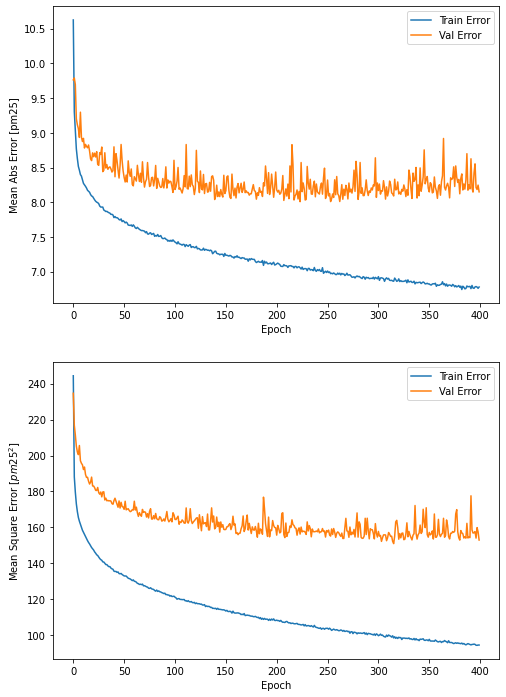

In [19]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [pm25]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  # plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$pm25^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  # plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

모델에 test data를 넣어 분포도로 결과를 확인한다.<br>
보통 오른쪽 대각선이 나와야 잘 나온것이다.

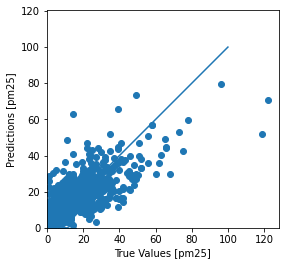

In [20]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pm25]')
plt.ylabel('Predictions [pm25]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

오차분포를 확인한다.

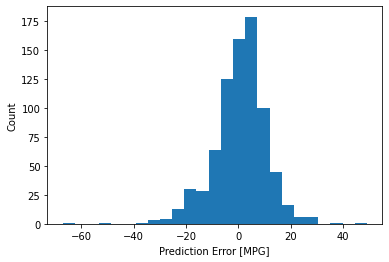

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [22]:
from sklearn.metrics import r2_score
r2_y_predict = r2_score(test_labels, test_predictions)
print('R2 : ', r2_y_predict)

R2 :  0.466415793755655
